In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
import numpy.random as npr
from robust_loss_pytorch import distribution
from sklearn.preprocessing import scale as scaler
import random
import torch.nn as nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Construct some regression data with some extreme outliers.
np.random.seed(1234)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]
    
class Poly2RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]
    
class Poly2RegressionModel_with_class(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel_with_class, self).__init__() 
        self.linear = torch.nn.Linear(3, 1)
    def forward(self, x, c): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        x = torch.cat([x, c.view(-1,1)], axis=1)
        return self.linear(x)[:,0]

def plot_regression(regression, u=None, c=None):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(min(x), max(x), 500)
    if c is None:
        y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    else:
        y_plot = regression(torch.Tensor(x_plot), c).detach().numpy()
#     y_plot_true = x_plot * scale_true + shift_true
    
    plt.figure(0, figsize=(4,4))
    if u is not None:
        sns.scatterplot(x, y, hue=U)
    else:
        sns.scatterplot(x, y)
#     plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='navy', label='regressor')
    plt.legend()

In [2]:
def generate_delta_noise(n:int, x_range:list, delta=10, rate=0.01, beta1=3, beta0=0, scale=1, hetero=False):
    X = npr.uniform(x_range[0], x_range[1], n)
    X = np.array(sorted(X))
    scales = scale*np.ones(len(X))
    if hetero:
        scales[X>0]+=(X**2+5*X)[X>0]
    Y = npr.normal(beta1*X+beta0, scales)
    
    
    noise = np.array([False]*n)
    idx = np.random.choice(int(n/5), int(n*rate), replace=False)
    noise[idx]= True
    Y[noise] = npr.normal(beta1*(X[noise]+delta)+beta0)
    X = scaler(X)
    Y = scaler(Y)
    return X, Y, noise

# Heteroskedastic data

Text(0.5, 1.0, 'n = 1000')

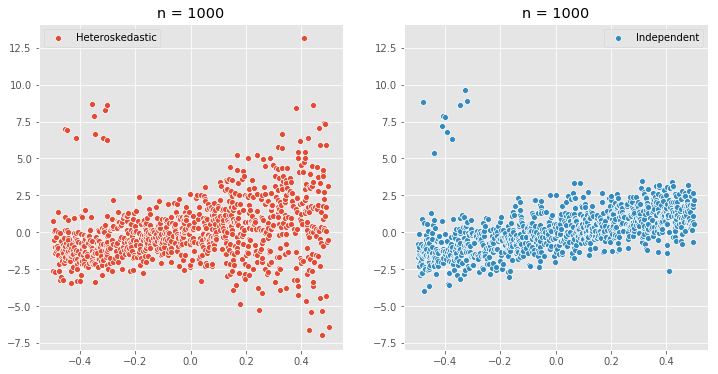

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

x_indep, y_indep, noise_indep = generate_delta_noise(1000, [-0.5, 0.5], delta=3, rate=0.01, hetero=False, beta0=0)
x_hetero, y_hetero, noise_hetero = generate_delta_noise(1000, [-0.5, 0.5], delta=3, rate=0.01, hetero=True, beta0=0)
ax[0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Heteroskedastic', color=palette[0], ax=ax[0])
ax[1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Independent', color=palette[1], ax=ax[1])
ax[0].set_title('n = 1000')
ax[1].set_title('n = 1000')
# plt.savefig('synthetic_data_noise.png')

# Density data

Text(0.5, 1.0, 'n = 250')

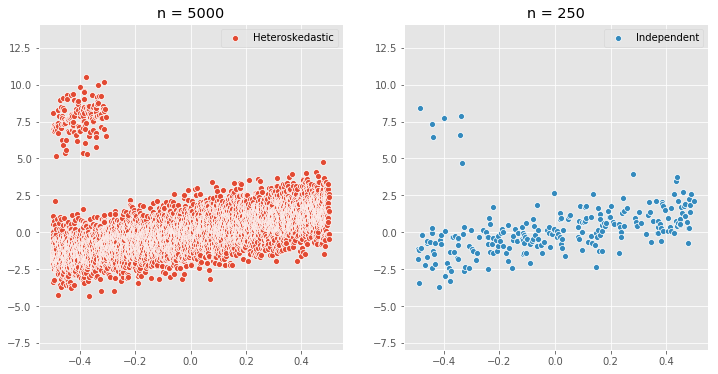

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

x_dense, y_dense, noise_dense = generate_delta_noise(5000, [-0.5, 0.5], delta=3, rate=0.03, hetero=False, beta0=0)
x_sparse, y_sparse, noise_sparse = generate_delta_noise(250, [-0.5, 0.5], delta=3, rate=0.03, hetero=False, beta0=0)
ax[0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Heteroskedastic', color=palette[0], ax=ax[0])
ax[1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Independent', color=palette[1], ax=ax[1])
ax[0].set_title('n = 5000')
ax[1].set_title('n = 250')
# plt.savefig('synthetic_data_sparse.png')

## Linear regression with regular MSE

0   : loss=222.929886
500 : loss=202.370911
1000: loss=202.369217
1500: loss=202.369217
MSE: 4.047384


OrderedDict([('weight', Parameter containing:
              tensor([[2.3387]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.1195], requires_grad=True))])

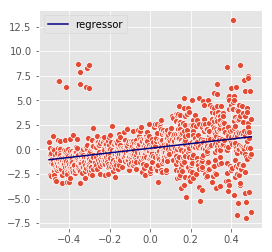

In [69]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(list(params), lr = 0.01) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

0   : loss=138.706741
500 : loss=89.038612
1000: loss=88.521133
1500: loss=88.521049
MSE: 1.770421


OrderedDict([('weight', Parameter containing:
              tensor([[2.6582]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.1127], requires_grad=True))])

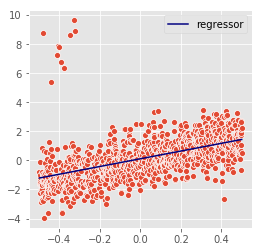

In [70]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

## Linear regression with Adaptive Roust loss

0   : loss=3.150072  alpha=1.997990  scale=1.006333
500 : loss=2.105104  alpha=1.877680  scale=1.899473
1000: loss=2.019830  alpha=0.808804  scale=1.106307
1500: loss=2.011803  alpha=0.556077  scale=0.907786
2000: loss=2.011796  alpha=0.549535  scale=0.902452
MSE: 4.069705


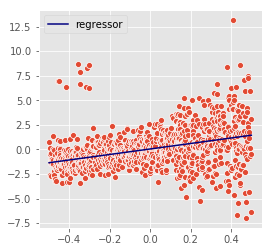

In [71]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
hetero_alpha = []
hetero_scale = []
for epoch in range(2500): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    hetero_alpha.append(adaptive.alpha()[0,0].data.numpy())
    hetero_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))

0   : loss=2.545968  alpha=1.997990  scale=1.006333
500 : loss=1.697752  alpha=1.948792  scale=1.297938
1000: loss=1.533403  alpha=0.635213  scale=0.599546
1500: loss=1.533402  alpha=0.633565  scale=0.598917
2000: loss=1.533402  alpha=0.633565  scale=0.598917


OrderedDict([('weight', Parameter containing:
              tensor([[3.0864]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([-0.0055], requires_grad=True))])

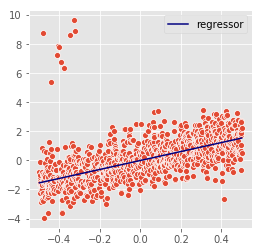

In [72]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
indep_alpha = []
indep_scale = []
for epoch in range(2500): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    indep_alpha.append(adaptive.alpha()[0,0].data.numpy())
    indep_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters

Text(0, 0.5, 'log alpha')

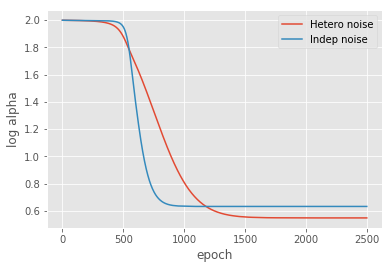

In [73]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_alpha), label="Hetero noise")
sns.lineplot(np.arange(len(hetero_alpha)), np.array(indep_alpha), label="Indep noise")
plt.xlabel('epoch')
plt.ylabel('log alpha')
# plt.savefig('alpha_convergence_noise.png')

Text(0, 0.5, 'log scale parameter')

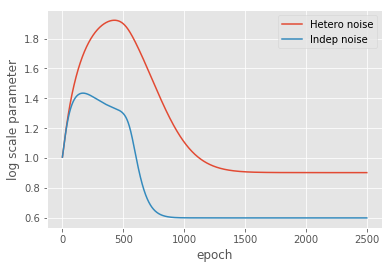

In [74]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_scale), label="Hetero noise")
sns.lineplot(np.arange(len(hetero_alpha)), np.array(indep_scale), label="Indep noise")
plt.xlabel('epoch')
plt.ylabel('log scale parameter')
# plt.savefig('scale_convergence_noise.png')

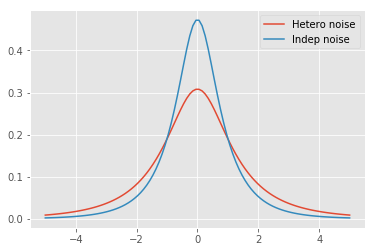

In [75]:
dist = distribution.Distribution()
alpha=hetero_alpha[-1]
scale=hetero_scale[-1]
x_range = 5
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Hetero noise')

alpha=indep_alpha[-1] 
scale=indep_scale[-1]
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Indep noise')
# plt.savefig('learned_kernel_noise.png')

0   : loss=2.694309  alpha=1.997990  scale=1.006333
500 : loss=1.917671  alpha=1.473680  scale=1.509385
1000: loss=1.680591  alpha=0.343716  scale=0.574573
1500: loss=1.680576  alpha=0.338589  scale=0.570371
2000: loss=1.680576  alpha=0.338589  scale=0.570371
MSE: 3.426781


OrderedDict([('weight', Parameter containing:
              tensor([[2.9933]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.0043], requires_grad=True))])

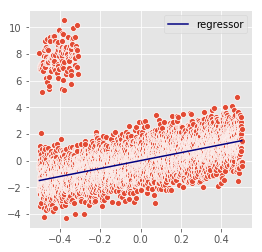

In [76]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_dense)
y = torch.Tensor(y_dense)
dense_alpha = []
dense_scale = []
for epoch in range(2500): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    dense_alpha.append(adaptive.alpha()[0,0].data.numpy())
    dense_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

0   : loss=2.705651  alpha=1.997990  scale=1.006333
500 : loss=1.857752  alpha=1.624346  scale=1.458010
1000: loss=1.620585  alpha=0.371263  scale=0.551790
1500: loss=1.620581  alpha=0.368244  scale=0.549581
2000: loss=1.620580  alpha=0.368244  scale=0.549581
MSE: 2.784950


OrderedDict([('weight', Parameter containing:
              tensor([[2.5433]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.0053], requires_grad=True))])

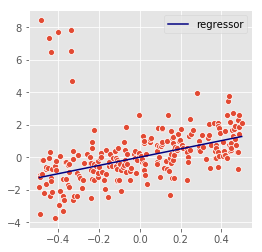

In [77]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_sparse)
y = torch.Tensor(y_sparse)
sparse_alpha = []
sparse_scale = []
for epoch in range(2500): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    sparse_alpha.append(adaptive.alpha()[0,0].data.numpy())
    sparse_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

Text(0, 0.5, 'log alpha')

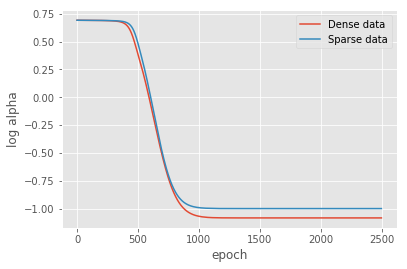

In [78]:
sns.lineplot(np.arange(len(dense_alpha)), np.log(np.array(dense_alpha)), label="Dense data")
sns.lineplot(np.arange(len(dense_alpha)), np.log(np.array(sparse_alpha)), label="Sparse data")
plt.xlabel('epoch')
plt.ylabel('log alpha')
# plt.savefig('alpha_convergence_sparse.png')

Text(0, 0.5, 'log scale parameter')

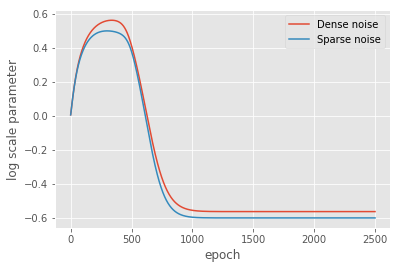

In [79]:
sns.lineplot(np.arange(len(dense_alpha)), np.log(np.array(dense_scale)), label="Dense noise")
sns.lineplot(np.arange(len(dense_alpha)), np.log(np.array(sparse_scale)), label="Sparse noise")
plt.xlabel('epoch')
plt.ylabel('log scale parameter')
# plt.savefig('scale_convergence_sparse.png')

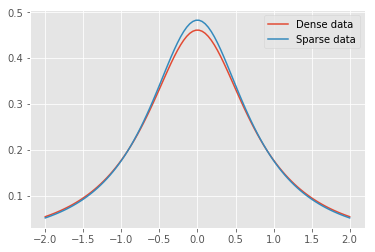

In [80]:
dist = distribution.Distribution()
alpha=dense_alpha[-1]
scale=dense_scale[-1]
x_range = 2
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Dense data')

alpha=sparse_alpha[-1] 
scale=sparse_scale[-1]
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Sparse data')
# plt.savefig('learned_kernel_sparse.png')

# Optimize Alpha for each data

In [81]:
# Fit a linear regression using mean squared error.
alpha_dense = nn.Parameter(torch.Tensor([0]*len(x_dense)))
scale_dense = nn.Parameter(torch.Tensor([0]*len(x_dense)))
optimizer = torch.optim.Adam([scale_dense, alpha_dense], lr = 1e-4) 
x = torch.Tensor(x_dense)
y = torch.Tensor(y_dense)
for epoch in range(20000): 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - x, alpha=torch.exp(alpha_dense), scale=torch.exp(scale_dense)))
    loss = loss + scale_dense.mean() + dist.log_base_partition_function(torch.exp(alpha_dense)).mean()

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=1.846371
1000: loss=1.740012
2000: loss=1.651814
3000: loss=1.573053
4000: loss=1.499182
5000: loss=1.426011
6000: loss=1.333528
7000: loss=1.267174
8000: loss=1.221024
9000: loss=1.183838
10000: loss=1.152643
11000: loss=1.125748
12000: loss=1.102331
13000: loss=1.081774
14000: loss=1.063611
15000: loss=1.047541
16000: loss=1.033258
17000: loss=1.020544
18000: loss=1.009211
19000: loss=0.999110


Text(0.5, 0, 'X')

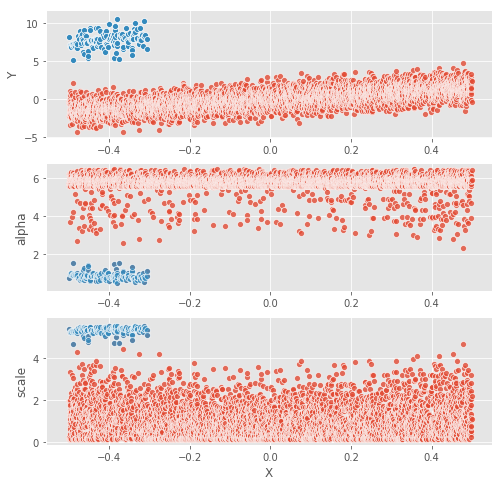

In [82]:
alpha_hat_dense = torch.exp(alpha_dense).data.numpy()
scale_hat_dense = torch.exp(scale_dense).data.numpy()
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_dense], y.data.numpy()[noise_dense], ax=ax[0])

sns.scatterplot(x.data.numpy(), alpha_hat_dense, ax=ax[1], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_dense], alpha_hat_dense[noise_dense], ax=ax[1], alpha=0.8)

sns.scatterplot(x.data.numpy(), scale_hat_dense, ax=ax[2], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_dense], scale_hat_dense[noise_dense], ax=ax[2], alpha=0.8)

ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

In [83]:
# Fit a linear regression using mean squared error.
alpha_sparse = nn.Parameter(torch.Tensor([0]*len(x_sparse)))
scale_sparse = nn.Parameter(torch.Tensor([0]*len(x_sparse)))
optimizer = torch.optim.Adam([scale_sparse, alpha_sparse], lr = 1e-4) 
x = torch.Tensor(x_sparse)
y = torch.Tensor(y_sparse)
for epoch in range(20000): 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        x - y, alpha=torch.exp(alpha_sparse), scale=torch.exp(scale_sparse)))
    loss = loss + scale_sparse.mean() + dist.log_base_partition_function(torch.exp(alpha_sparse)).mean()

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=1.768325
1000: loss=1.660952
2000: loss=1.569231
3000: loss=1.485498
4000: loss=1.405581
5000: loss=1.325078
6000: loss=1.219048
7000: loss=1.144942
8000: loss=1.094835
9000: loss=1.054264
10000: loss=1.019875
11000: loss=0.990009
12000: loss=0.963811
13000: loss=0.940587
14000: loss=0.919966
15000: loss=0.901543
16000: loss=0.885112
17000: loss=0.870589
18000: loss=0.857722
19000: loss=0.846310


Text(0.5, 0, 'X')

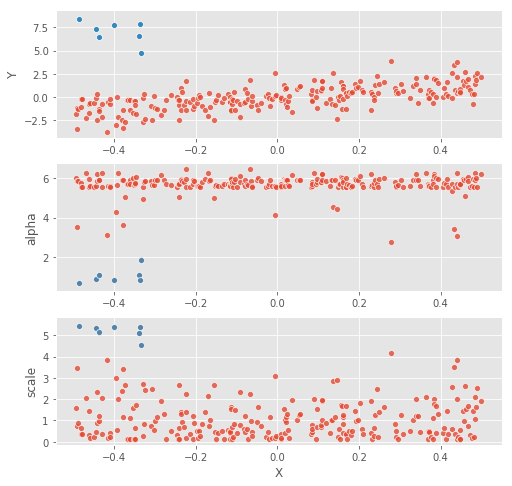

In [84]:
alpha_hat_sparse = torch.exp(alpha_sparse).data.numpy()
scale_hat_sparse = torch.exp(scale_sparse).data.numpy()
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_sparse], y.data.numpy()[noise_sparse], ax=ax[0])

sns.scatterplot(x.data.numpy(), alpha_hat_sparse, ax=ax[1], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_sparse], alpha_hat_sparse[noise_sparse], ax=ax[1], alpha=0.8)

sns.scatterplot(x.data.numpy(), scale_hat_sparse, ax=ax[2], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_sparse], scale_hat_sparse[noise_sparse], ax=ax[2], alpha=0.8)

ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

In [85]:
# Fit a linear regression using mean squared error.
alpha_indep = nn.Parameter(torch.Tensor([0]*len(x_indep)))
scale_indep = nn.Parameter(torch.Tensor([0]*len(x_indep)))
optimizer = torch.optim.Adam([scale_indep, alpha_indep], lr = 1e-4) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
for epoch in range(20000): 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        x - y, alpha=torch.exp(alpha_indep), scale=torch.exp(scale_indep)))
    loss = loss + scale_indep.mean() + dist.log_base_partition_function(torch.exp(alpha_indep)).mean()

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=1.709458
1000: loss=1.623831
2000: loss=1.549091
3000: loss=1.479770
4000: loss=1.412825
5000: loss=1.344807
6000: loss=1.255646
7000: loss=1.192340
8000: loss=1.149405
9000: loss=1.115235
10000: loss=1.086334
11000: loss=1.061529
12000: loss=1.040131
13000: loss=1.021514
14000: loss=1.005270
15000: loss=0.991069
16000: loss=0.978575
17000: loss=0.967556
18000: loss=0.957797
19000: loss=0.949157


Text(0.5, 0, 'X')

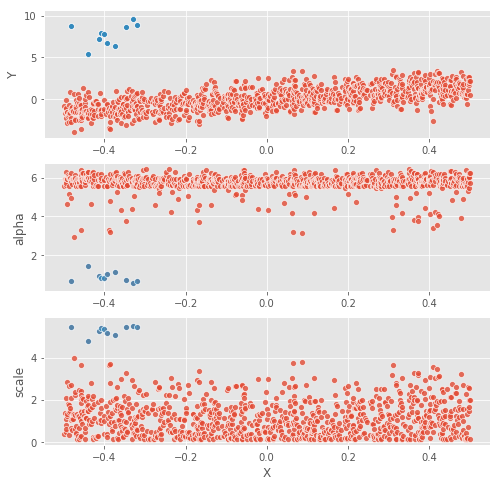

In [86]:
alpha_hat_indep = torch.exp(alpha_indep).data.numpy()
scale_hat_indep = torch.exp(scale_indep).data.numpy()
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_indep], y.data.numpy()[noise_indep], ax=ax[0])

sns.scatterplot(x.data.numpy(), alpha_hat_indep, ax=ax[1], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_indep], alpha_hat_indep[noise_indep], ax=ax[1], alpha=0.8)

sns.scatterplot(x.data.numpy(), scale_hat_indep, ax=ax[2], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_indep], scale_hat_indep[noise_indep], ax=ax[2], alpha=0.8)

ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

In [87]:
# Fit a linear regression using mean squared error.
alpha_hetero = nn.Parameter(torch.Tensor([0]*len(x_hetero)))
scale_hetero = nn.Parameter(torch.Tensor([0]*len(x_hetero)))
optimizer = torch.optim.Adam([scale_hetero, alpha_hetero]+list(params), lr = 1e-4) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
for epoch in range(20000): 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        x - y, alpha=torch.exp(alpha_hetero), scale=torch.exp(scale_hetero)))
    loss = loss + scale_hetero.mean() + dist.log_base_partition_function(torch.exp(alpha_hetero)).mean()

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=2.082984
1000: loss=1.963435
2000: loss=1.868871
3000: loss=1.787439
4000: loss=1.713343
5000: loss=1.642141
6000: loss=1.557246
7000: loss=1.495255
8000: loss=1.451419
9000: loss=1.415924
10000: loss=1.386165
11000: loss=1.360141
12000: loss=1.337468
13000: loss=1.317674
14000: loss=1.300196
15000: loss=1.284713
16000: loss=1.271004
17000: loss=1.258839
18000: loss=1.248063
19000: loss=1.238494


Text(0.5, 0, 'X')

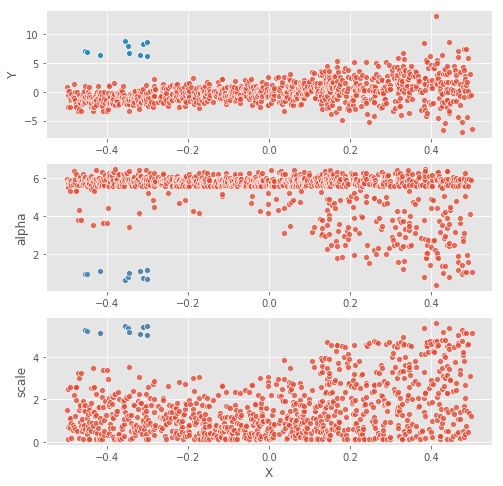

In [88]:
alpha_hat_hetero = torch.exp(alpha_hetero).data.numpy()
scale_hat_hetero = torch.exp(scale_hetero).data.numpy()
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_hetero], y.data.numpy()[noise_hetero], ax=ax[0])

sns.scatterplot(x.data.numpy(), alpha_hat_hetero, ax=ax[1], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_hetero], alpha_hat_hetero[noise_hetero], ax=ax[1], alpha=0.8)

sns.scatterplot(x.data.numpy(), scale_hat_hetero, ax=ax[2], alpha=0.8)
sns.scatterplot(x.data.numpy()[noise_hetero], scale_hat_hetero[noise_hetero], ax=ax[2], alpha=0.8)

ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

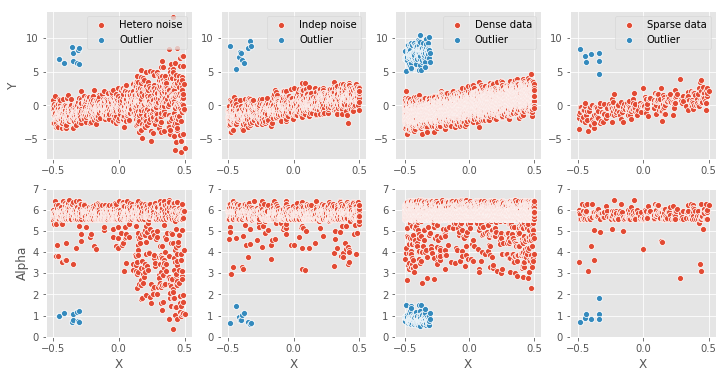

In [91]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))
ax[0][0].set_ylabel('Y')
ax[0][0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Hetero noise', color=palette[0], ax=ax[0][0])
sns.scatterplot(x_hetero[noise_hetero], y_hetero[noise_hetero], label='Outlier', color=palette[1], ax=ax[0][0])

ax[0][1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Indep noise', color=palette[0], ax=ax[0][1])
sns.scatterplot(x_indep[noise_indep], y_indep[noise_indep], label='Outlier', color=palette[1], ax=ax[0][1])

ax[0][2].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Dense data', color=palette[0], ax=ax[0][2])
sns.scatterplot(x_dense[noise_dense], y_dense[noise_dense], label='Outlier', color=palette[1], ax=ax[0][2])

ax[0][3].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Sparse data', color=palette[0], ax=ax[0][3])
sns.scatterplot(x_sparse[noise_sparse], y_sparse[noise_sparse], label='Outlier', color=palette[1], ax=ax[0][3])

ax[1][0].set_ylabel('Alpha')
ax[1][0].set_xlabel('X')
ax[1][0].set_ylim([0, 7])
sns.scatterplot(x_hetero, alpha_hat_hetero, color=palette[0], ax=ax[1][0])
sns.scatterplot(x_hetero[noise_hetero], alpha_hat_hetero[noise_hetero], color=palette[1], ax=ax[1][0])

ax[1][1].set_ylim([0, 7])
ax[1][1].set_xlabel('X')
sns.scatterplot(x_indep, alpha_hat_indep, color=palette[0], ax=ax[1][1])
sns.scatterplot(x_indep[noise_indep], alpha_hat_indep[noise_indep], color=palette[1], ax=ax[1][1])

ax[1][2].set_ylim([0, 7])
ax[1][2].set_xlabel('X')
sns.scatterplot(x_dense, alpha_hat_dense, color=palette[0], ax=ax[1][2])
sns.scatterplot(x_dense[noise_dense], alpha_hat_dense[noise_dense], color=palette[1], ax=ax[1][2])

ax[1][3].set_ylim([0, 7])
ax[1][3].set_xlabel('X')
sns.scatterplot(x_sparse, alpha_hat_sparse, color=palette[0], ax=ax[1][3])
sns.scatterplot(x_sparse[noise_sparse], alpha_hat_sparse[noise_sparse], color=palette[1], ax=ax[1][3])

# plt.savefig('non_param_alpha.png')

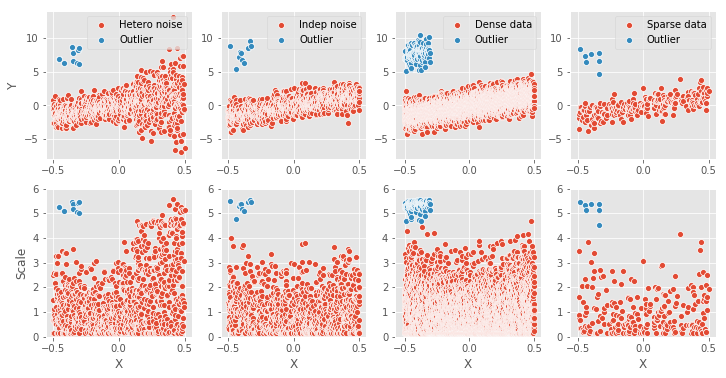

In [93]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))
ax[0][0].set_ylabel('Y')
ax[0][0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Hetero noise', color=palette[0], ax=ax[0][0])
sns.scatterplot(x_hetero[noise_hetero], y_hetero[noise_hetero], label='Outlier', color=palette[1], ax=ax[0][0])

ax[0][1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Indep noise', color=palette[0], ax=ax[0][1])
sns.scatterplot(x_indep[noise_indep], y_indep[noise_indep], label='Outlier', color=palette[1], ax=ax[0][1])

ax[0][2].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Dense data', color=palette[0], ax=ax[0][2])
sns.scatterplot(x_dense[noise_dense], y_dense[noise_dense], label='Outlier', color=palette[1], ax=ax[0][2])

ax[0][3].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Sparse data', color=palette[0], ax=ax[0][3])
sns.scatterplot(x_sparse[noise_sparse], y_sparse[noise_sparse], label='Outlier', color=palette[1], ax=ax[0][3])

ax[1][0].set_ylabel('Scale')
ax[1][0].set_xlabel('X')
ax[1][0].set_ylim([0, 6])
sns.scatterplot(x_hetero, scale_hat_hetero, color=palette[0], ax=ax[1][0])
sns.scatterplot(x_hetero[noise_hetero], scale_hat_hetero[noise_hetero], color=palette[1], ax=ax[1][0])

# ax[1][1].set_ylim([1.2, 2.1])
ax[1][1].set_xlabel('X')
ax[1][1].set_ylim([0, 6])
sns.scatterplot(x_indep, scale_hat_indep, color=palette[0], ax=ax[1][1])
sns.scatterplot(x_indep[noise_indep], scale_hat_indep[noise_indep], color=palette[1], ax=ax[1][1])

# ax[1][2].set_ylim([1.2, 2.1])
ax[1][2].set_xlabel('X')
ax[1][2].set_ylim([0, 6])
sns.scatterplot(x_dense, scale_hat_dense, color=palette[0], ax=ax[1][2])
sns.scatterplot(x_dense[noise_dense], scale_hat_dense[noise_dense], color=palette[1], ax=ax[1][2])

# ax[1][3].set_ylim([1.2, 2.1])
ax[1][3].set_xlabel('X')
ax[1][3].set_ylim([0, 6])
sns.scatterplot(x_sparse, scale_hat_sparse, color=palette[0], ax=ax[1][3])
sns.scatterplot(x_sparse[noise_sparse], scale_hat_sparse[noise_sparse], color=palette[1], ax=ax[1][3])

# plt.savefig('non_param_scale.png')